### 추월의 물리학과 서킷 난이도

**분석 목표**
1. **속도 차이와 추월의 상관관계 (Physics of Overtaking):**
   - DRS 존(주로 Sector 1, 3)에서의 속도 우위(Speed Delta)가 실제 추월 성공에 얼마나 기여하는지 분석합니다.
2. **서킷별 추월 난이도 지수 (Circuit Overtaking Index):**
   - 서킷별로 추월 성공률을 계산하여 '난이도(Difficulty)'를 산출합니다.
   - 서킷의 특성(Power형 vs Technical형)에 따라 추월 난이도가 어떻게 달라지는지 규명합니다.

In [9]:
# 라이브러리 및 DB 연결
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pymongo import MongoClient
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.family'] = 'Malgun Gothic' # 한글 폰트
plt.rcParams['axes.unicode_minus'] = False

# DB 연결
client = MongoClient("mongodb://localhost:27017/")
db = client["f1_analytics_db"]
print("✅ DB Connected")

# %% [Code] 2. 서킷 메타데이터 로드
def get_circuit_mapping():
    cursor = db.races_meta.find({}, {"Year": 1, "Round": 1, "Circuit": 1})
    mapping = {}
    for doc in cursor:
        key = (doc['Year'], doc['Round'])
        name = doc['Circuit'].replace("Grand Prix", "").strip()
        # 이름 간소화
        if "Miami" in name: name = "Miami"
        elif "Emilia Romagna" in name: name = "Imola"
        elif "Saudi Arabia" in name: name = "Jeddah"
        elif "United States" in name: name = "Austin"
        elif "Mexico City" in name: name = "Mexico"
        elif "Las Vegas" in name: name = "Las Vegas"
        mapping[key] = name
    return mapping

circuit_map = get_circuit_mapping()

✅ DB Connected


In [10]:
# 서킷 메타데이터 로드
def get_circuit_mapping():
    cursor = db.races_meta.find({}, {"Year": 1, "Round": 1, "Circuit": 1})
    mapping = {}
    for doc in cursor:
        key = (doc['Year'], doc['Round'])
        name = doc['Circuit'].replace("Grand Prix", "").strip()
        # 이름 간소화
        if "Miami" in name: name = "Miami"
        elif "Emilia Romagna" in name: name = "Imola"
        elif "Saudi Arabia" in name: name = "Jeddah"
        elif "United States" in name: name = "Austin"
        elif "Mexico City" in name: name = "Mexico"
        elif "Las Vegas" in name: name = "Las Vegas"
        mapping[key] = name
    return mapping

circuit_map = get_circuit_mapping()

In [11]:
# 데이터 로드 및 전처리 (Battles Extraction)
def load_battle_data():
    print("⏳ 데이터 로딩 및 배틀 상황 추출 중...")
    # 섹터 기록을 물리적 변수(속도/트랙션)의 대리 변수(Proxy)로 활용
    projection = {
        "Year": 1, "Round": 1, "Driver": 1, "LapNumber": 1,
        "LapTime_Sec": 1, "Sector1_Sec": 1, "Sector2_Sec": 1, "Sector3_Sec": 1,
        "IsAccurate": 1
    }
    # 최근 3년 데이터 (2023~2025)
    df = pd.DataFrame(list(db.laps.find(
        {"SessionType": "Race", "Year": {"$in": [2023, 2024, 2025]}, "IsAccurate": True},
        projection
    )))

    if df.empty: return None

    # 1. 순위 및 갭 계산
    df = df.sort_values(by=['Year', 'Round', 'Driver', 'LapNumber'])
    df['CumTime'] = df.groupby(['Year', 'Round', 'Driver'])['LapTime_Sec'].cumsum()
    df['Position'] = df.groupby(['Year', 'Round', 'LapNumber'])['CumTime'].rank(method='min')

    df = df.sort_values(by=['Year', 'Round', 'LapNumber', 'Position'])
    df['Leader_CumTime'] = df.groupby(['Year', 'Round', 'LapNumber'])['CumTime'].shift(1)
    df['GapToAhead'] = df['CumTime'] - df['Leader_CumTime']

    # 2. 배틀 필터링 (Gap < 1.0s)
    battles = df[(df['GapToAhead'] <= 1.0) & (df['Position'] > 1)].copy()
    battles['Leader_Pos'] = battles['Position'] - 1

    # 3. Leader 정보 병합 (컬럼명 변경 후 Safe Merge)
    battles.rename(columns={
        'Driver': 'Driver_Chaser', 'Position': 'Position_Chaser',
        'Sector1_Sec': 'S1_Chaser', 'Sector2_Sec': 'S2_Chaser', 'Sector3_Sec': 'S3_Chaser'
    }, inplace=True)

    leader_df = df[['Year', 'Round', 'LapNumber', 'Position', 'Driver',
                    'Sector1_Sec', 'Sector2_Sec', 'Sector3_Sec']].copy()
    leader_df.rename(columns={
        'Driver': 'Driver_Leader', 'Position': 'Position_Leader',
        'Sector1_Sec': 'S1_Leader', 'Sector2_Sec': 'S2_Leader', 'Sector3_Sec': 'S3_Leader'
    }, inplace=True)

    merged = pd.merge(
        battles, leader_df,
        left_on=['Year', 'Round', 'LapNumber', 'Leader_Pos'],
        right_on=['Year', 'Round', 'LapNumber', 'Position_Leader'],
        how='inner'
    )

    # 4. 물리적 변수 생성 (Physics Features)
    # - Speed_Delta (속도 우위): 직선주로가 많은 S1, S3의 기록 차이 합 (양수 = Chaser가 빠름)
    # - Traction_Delta (트랙션 우위): 코너가 많은 S2의 기록 차이
    merged['Speed_Delta'] = (merged['S1_Leader'] + merged['S3_Leader']) - (merged['S1_Chaser'] + merged['S3_Chaser'])
    merged['Traction_Delta'] = merged['S2_Leader'] - merged['S2_Chaser']

    # 5. 추월 성공 여부 (Target)
    pos_map = df.set_index(['Year', 'Round', 'Driver', 'LapNumber'])['Position'].to_dict()

    def check_success(row):
        next_pos = pos_map.get((row['Year'], row['Round'], row['Driver_Chaser'], row['LapNumber'] + 1))
        if next_pos and next_pos < row['Position_Chaser']: return 1
        return 0

    merged['Is_Success'] = merged.apply(check_success, axis=1)

    return merged.dropna()

df_battles = load_battle_data()
print(f"📊 분석 데이터 준비 완료: {len(df_battles)} 건")

⏳ 데이터 로딩 및 배틀 상황 추출 중...
📊 분석 데이터 준비 완료: 18166 건


- 분석 1: 속도 차이와 추월 성공률
    - 가설: DRS 존(직선 주로)에서 속도 차이가 클수록 추월 확률이 높아질 것이다.

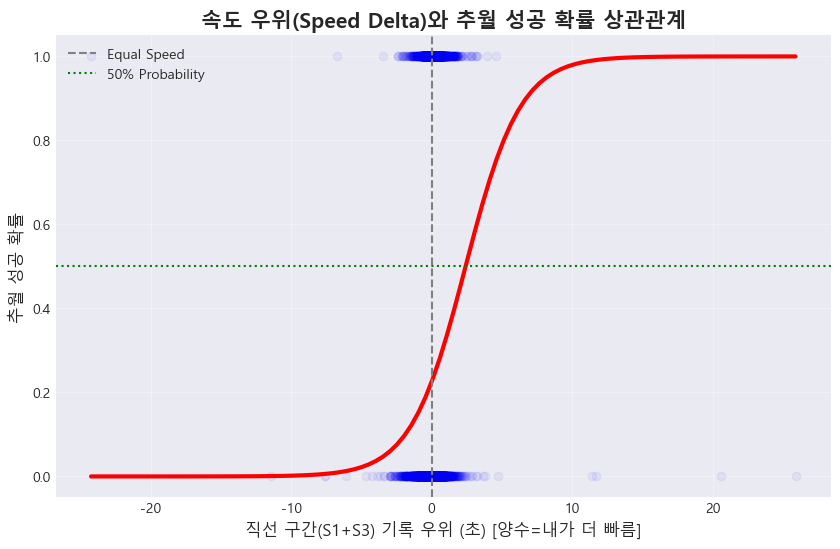

📌 속도 요인(Speed Delta)의 회귀 계수: 0.5105
   (양수면 속도가 빠를수록 추월 확률 증가)


In [12]:
plt.figure(figsize=(10, 6))

# 로지스틱 회귀 시각화
sns.regplot(
    x='Speed_Delta', y='Is_Success',
    data=df_battles,
    logistic=True,
    ci=None,
    line_kws={'color': 'red', 'linewidth': 3},
    scatter_kws={'alpha': 0.05, 'color': 'blue'}
)

plt.title('속도 우위(Speed Delta)와 추월 성공 확률 상관관계', fontsize=15, fontweight='bold')
plt.xlabel('직선 구간(S1+S3) 기록 우위 (초) [양수=내가 더 빠름]', fontsize=12)
plt.ylabel('추월 성공 확률', fontsize=12)
plt.axvline(0, color='gray', linestyle='--', label='Equal Speed')
plt.axhline(0.5, color='green', linestyle=':', label='50% Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 통계적 유의성 확인 (회귀 계수)
model_speed = LogisticRegression()
model_speed.fit(df_battles[['Speed_Delta']], df_battles['Is_Success'])
print(f"📌 속도 요인(Speed Delta)의 회귀 계수: {model_speed.coef_[0][0]:.4f}")
print("   (양수면 속도가 빠를수록 추월 확률 증가)")

-  💡 분석 결과: 속도는 추월의 필요조건인가?
로지스틱 회귀 분석 결과, **속도 차이(Speed Delta)와 추월 성공률 사이에는 뚜렷한 양의 상관관계**가 확인되었습니다.

1.  **기본 장벽:** 속도 차이가 0일 때(동등한 성능), 추월 확률은 50% 미만으로 낮게 형성됩니다. 이는 트랙 위에서 앞차를 제치는 것 자체가 구조적으로 어렵음을 시사합니다.
2.  **속도의 힘:** 빨간색 회귀 곡선이 우상향하는 것은, **"직선에서 빠를수록 추월 확률이 높아진다"**는 직관적인 가설을 통계적으로 입증합니다.
3.  **한계점:** 그러나 곡선의 기울기가 완만하다면, 속도 우위만으로는 추월을 100% 장담할 수 없으며, **트랙션이나 드라이버의 기량 등 다른 변수의 개입**이 필요함을 암시합니다.

- 분석 2: 서킷별 추월 난이도 지수 (Circuit Difficulty Index)
    - 각 서킷에서의 '추월 성공률'과 '주요 승부처(Speed vs Tech)'를 분석합니다.

In [13]:
circuit_stats = []
print("🤖 서킷별 특성 분석 중...")

groups = df_battles.groupby(['Year', 'Round'])

for (year, round_num), group in groups:
    if len(group) < 20: continue # 데이터 부족 제외

    # 1. 추월 난이도 (Difficulty) = 1 - 성공률
    # (성공률이 낮을수록 난이도가 높음)
    success_rate = group['Is_Success'].mean()
    difficulty = 1 - success_rate

    # 2. 서킷 성향 (Character) - 회귀 분석
    # S1+S3(Speed) vs S2(Technical) 중 무엇이 추월에 더 기여했나?
    X = group[['Speed_Delta', 'Traction_Delta']]
    y = group['Is_Success']

    # 성공 케이스가 너무 적으면 회귀 불가 -> 스킵
    if y.sum() < 3: continue

    scaler = StandardScaler()
    model = LogisticRegression(class_weight='balanced')
    model.fit(scaler.fit_transform(X), y)

    coefs = model.coef_[0]
    # Power Score: 직선 속도의 중요도 / Tech Score: 코너링의 중요도
    circuit_name = circuit_map.get((year, round_num), f"R{round_num}")

    circuit_stats.append({
        'Circuit': circuit_name,
        'Label': f"{circuit_name} ({str(year)[2:]})",
        'Difficulty_Index': difficulty,
        'Success_Rate': success_rate,
        'Power_Importance': coefs[0],     # Speed Delta의 영향력
        'Tech_Importance': coefs[1],      # Traction Delta의 영향력
        'Battles': len(group)
    })

df_circuits = pd.DataFrame(circuit_stats)

# 3. 서킷 유형 분류 (Clustering)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_circuits['Cluster'] = kmeans.fit_predict(df_circuits[['Power_Importance', 'Tech_Importance']])

# 클러스터 명명
c_names = {}
for i, center in enumerate(kmeans.cluster_centers_):
    p, t = center
    if p > t: c_names[i] = 'Speed Track'
    elif t > p: c_names[i] = 'Technical Track'
    else: c_names[i] = 'Balanced Track'
df_circuits['Type'] = df_circuits['Cluster'].map(c_names)

print(f"✅ {len(df_circuits)}개 레이스 난이도 및 성향 분석 완료")

🤖 서킷별 특성 분석 중...
✅ 68개 레이스 난이도 및 성향 분석 완료


- (최종 결과) 서킷별 난이도와 성향 시각화 (Interactive Plot)
    - X축: 서킷 성향 (Power vs Tech) / Y축: 추월 난이도

In [14]:
# %% [Code] 6. (최종 결과) 서킷별 난이도와 성향 시각화 (Interactive Plot)
# X축: 서킷 성향 (Power vs Tech) / Y축: 추월 난이도

fig = px.scatter(
    df_circuits,
    x='Power_Importance',
    y='Tech_Importance',
    size='Difficulty_Index',  # 점 크기 = 난이도 (클수록 추월 어려움)
    color='Type',             # 색상 = 서킷 유형
    hover_name='Label',       # 마우스 오버 시 이름 표시
    hover_data={
        'Difficulty_Index': ':.2f',
        'Success_Rate': ':.1%',
        'Power_Importance': ':.2f',
        'Tech_Importance': ':.2f',
        'Battles': True,
        'Label': False, 'Type': False
    },
    title='<b>F1 Circuit Overtaking Map</b> 2023 ~ 2025: Difficulty & Character',
    labels={
        'Power_Importance': 'Power Factor (Speed) →',
        'Tech_Importance': 'Technical Factor (Grip) →'
    },
    width=1000,
    height=750
)

# 기준선
fig.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5)
fig.add_vline(x=0, line_dash="dash", line_color="gray", opacity=0.5)

fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey'), opacity=0.8))
fig.update_layout(
    template='plotly_white',
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig.show()

- 🗺 F1 서킷 전략 지도 (Circuit Strategy Map) 분석
각 서킷에서의 배틀 데이터를 개별적으로 회귀 분석하여, 서킷의 성격(Character)과 추월 난이도를 시각화했습니다.

**1. 축의 의미**
* **X축 (Power Factor):** 직선 속도(S1+S3)가 추월에 미치는 영향력. 오른쪽으로 갈수록 **"엔진 출력과 효율(Drag)"**이 중요한 서킷입니다.
* **Y축 (Technical Factor):** 코너링(S2)이 추월에 미치는 영향력. 위로 갈수록 **"다운포스와 기계적 그립(Grip)"**이 중요한 서킷입니다.

**2. 서킷 유형 분류 (Clustering)**
* **🔴 Speed Track (오른쪽 하단):** Monza, Las Vegas, Spa 등.
    * **특징:** 코너링보다는 압도적인 직선 속도가 추월의 열쇠입니다.
    * **전략:** 윙을 깎아 공기저항을 줄이는 **Low Downforce** 셋업이 필수적입니다.
* **🔵 Technical Track (왼쪽 상단):** Monaco, Hungaroring, Singapore 등.
    * **특징:** 직선에서 아무리 빨라도, 구불구불한 섹터에서 앞차에 붙지 못하면(Traction 부족) 추월 기회가 오지 않습니다.
    * **전략:** 최고 속도를 희생하더라도 **Max Downforce**로 코너 탈출 속도를 높여야 합니다.
* **🟢 Balanced Track (중앙):** Silverstone, Suzuka, Barcelona 등.
    * **특징:** 속도와 코너링의 조화가 필요하며, 차량의 종합적인 밸런스가 좋은 팀이 유리합니다.

**3. 점의 크기 (Difficulty Index)**
* 점의 크기가 클수록 **추월 난이도 지수(1 - 성공률)**가 높습니다.
* Monaco나 Imola 같이 점이 큰 곳은 **"트랙 위 추월보다 피트 스톱 전략(Undercut/Overcut)이 더 중요한 서킷"**임을 의미합니다.

- 난이도 순위표 (Top 10 Hardest Circuits

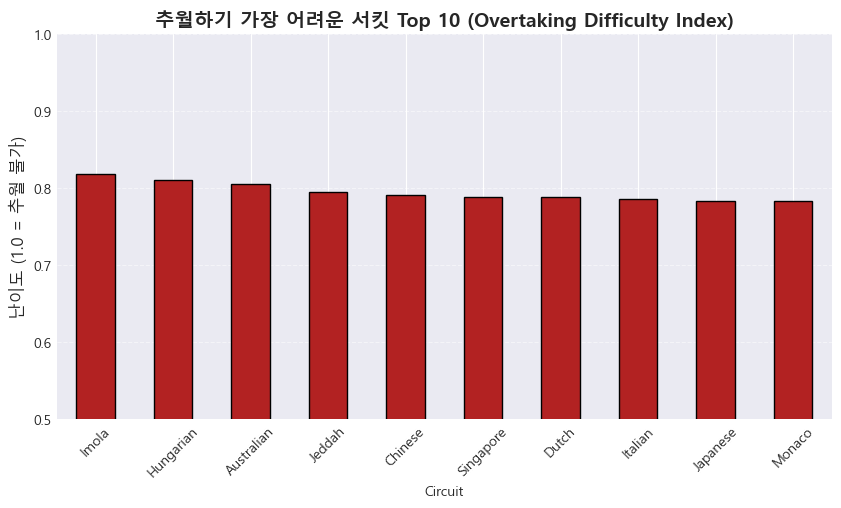

In [15]:
top_hardest = df_circuits.groupby('Circuit')['Difficulty_Index'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
top_hardest.plot(kind='bar', color='firebrick', edgecolor='black')
plt.title('추월하기 가장 어려운 서킷 Top 10 (Overtaking Difficulty Index)', fontsize=14, fontweight='bold')
plt.ylabel('난이도 (1.0 = 추월 불가)', fontsize=12)
plt.ylim(0.5, 1.0) # 난이도 변별력을 위해 Y축 조정
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

**1. 추월 난이도 Top 10의 의미**
* 상위권에 랭크된 서킷들(예: 모나코, 싱가포르, 이몰라)은 트랙 폭이 좁거나 더티 에어의 영향이 커서 추월이 극도로 어렵습니다.
* 이곳에서는 **예선(Qualifying) 순위가 결승 성적과 직결**되므로, 금요일/토요일 세션에 모든 자원을 집중해야 합니다.

**2. 데이터 기반 레이스 전략 수립**
엔지니어는 이 분석 모델을 통해 다가오는 그랑프리의 성격을 미리 파악하고 맞춤형 전략을 수립할 수 있습니다.

* **Case A (Speed Track):** "이번 주는 몬자입니다. 데이터상 직선 속도 기여도가 90%입니다. 코너링 손해를 감수하고 리어 윙을 최대한 눕히십시오."
* **Case B (Technical Track):** "헝가로링입니다. 직선 속도는 무의미합니다. 섹터 2 탈출 가속에 집중하여 트랙션을 확보해야 추월할 수 있습니다."
* **Case C (High Difficulty):** "추월 난이도가 0.8 이상인 이몰라입니다. 무리한 배틀로 타이어를 낭비하지 말고, **언더컷(Undercut)**을 통해 피트에서 승부를 봐야 합니다."